In [1]:
import numpy as np
import matplotlib.pyplot as plt
import logging
import scipy.signal as sig

from numpy import fft

logging.basicConfig(level=logging.INFO)

# Simulate test data

- Simulate a temporal impulse response
- Generate original position and amplitudes of scatterers
- Generate RF trace at original position and add modeled electronic noise
- Shift positions of scatteres and repeat previos step
- Decimate to realistic sampling frequency

In [2]:
def sim_trace(xs, amps, imp, tstart, tstop, fs, c:float=1540):
    """Generate RF data from position and amplitude of scatters"""
    if (np.ndim(xs) != 1) or (np.ndim(amps) !=1) or (np.ndim(imp) !=1):
        raise ValueError("xs, amps, and imp must be 1D")
    if len(xs) != len(amps):
        raise ValueError("xs and amps must be the same length")
    
    nt = int((tstop-tstart)*fs)
    t = tstart + np.arange(nt)/fs

    if len(imp) > nt:
        raise ValueError("Time trace mut be bigger than the impulse response")   

    # Calculate the frequency domain of an impulse response at t=0
    W = np.exp(-2j*np.pi*np.arange(nt)/nt)

    # convert continuous position to freactional index positions
    indxs = (2*fs*xs/c)
    amps = amps

    # Calculate the spatial impulse response of the given scatterer locations and amplitude
    SCAT = 0
    for amp, indx in zip(amps, indxs):
        SCAT += amp * W ** indx

    # Convolve (multiply in frequency) the temporal impulse response with spatial impulse response
    IMP = np.fft.fft(imp, nt) * W **(-len(imp)/2)
    TRACE = SCAT * IMP

    # Extract real component of signal --> rf data
    trace = np.real(np.fft.ifft(TRACE))
    return trace, t

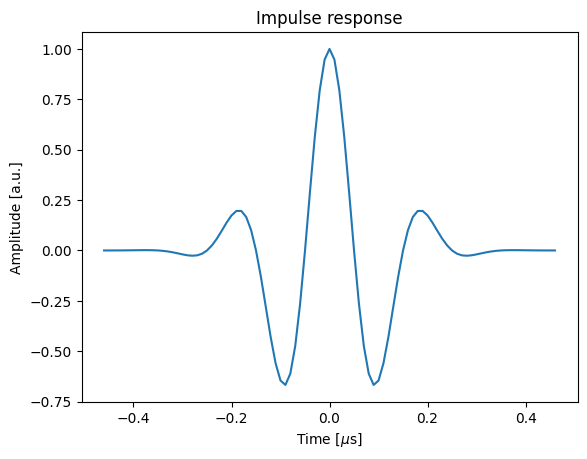

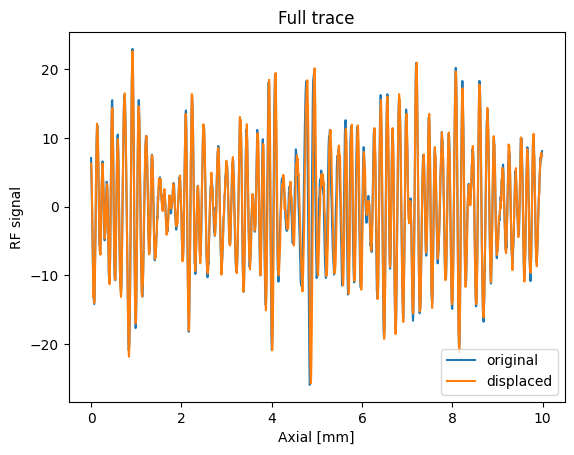

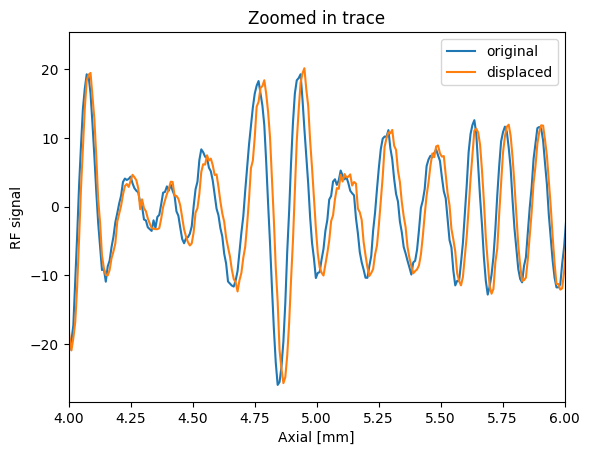

In [3]:
# define the imaging PSF
bw=70/100
f = 5E6
c = 1540
fs = 1E8

# Simulate a Gaussian impulse response
tc = sig.gausspulse('cutoff', bw=bw, tpr=-80, fc=f)
Ntc = np.ceil(tc*fs)
timp = (np.arange(2*Ntc+1)-Ntc)/fs
imp = sig.gausspulse(t=timp, bw=bw, tpr=-80, fc=f)

plt.figure()
plt.plot(1E6*timp, imp)
plt.xlabel("Time [$\\mu$s]")
plt.ylabel("Amplitude [a.u.]")
plt.title("Impulse response")
plt.show()

# define the scatterer field
xmin = 0E-6
xmax = 10E-3
Nx = int(1E4)

rng = np.random.default_rng(0)

x0 = rng.uniform(xmin, xmax, Nx)
a0 = rng.normal(0, 1, Nx)


# Undisplaced signal
trace0, t = sim_trace(x0, a0, imp, 0, 20E-3/c, fs, c)
x = c*t/2
trace0 += np.ptp(trace0) * rng.normal(0, 0.01, trace0.shape)

# define the displacement field
f_disp = lambda x, mag=20E-6: mag*np.exp(-(x-5E-3)**2/(1E-3**2))

x1 = x0 + f_disp(x0)

# displaced signal
trace1, _ = sim_trace(x1, a0, imp, 0, 20E-3/c, fs, c)
trace1 += np.ptp(trace0) * rng.normal(0, 0.01, trace1.shape)

plt.figure()
plt.plot(1E3*x, trace0, label='original')
plt.plot(1E3*x, trace1, label='displaced')
plt.legend()
plt.xlabel("Axial [mm]")
plt.ylabel("RF signal")
plt.title("Full trace")
plt.show()

plt.figure()
plt.plot(1E3*x, trace0, label='original')
plt.plot(1E3*x, trace1, label='displaced')
plt.legend()
plt.xlabel("Axial [mm]")
plt.ylabel("RF signal")
plt.title("Zoomed in trace")
plt.xlim(4, 6)
plt.show()

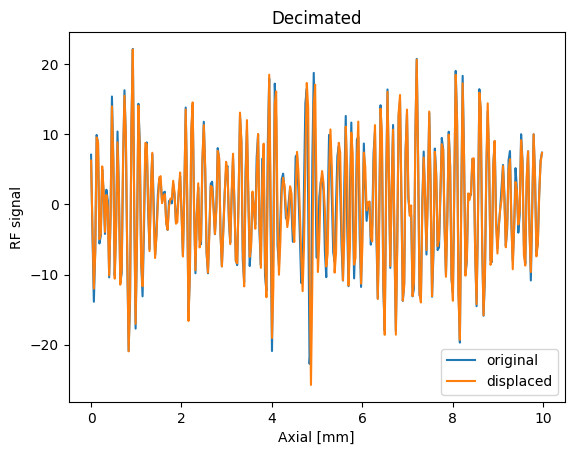

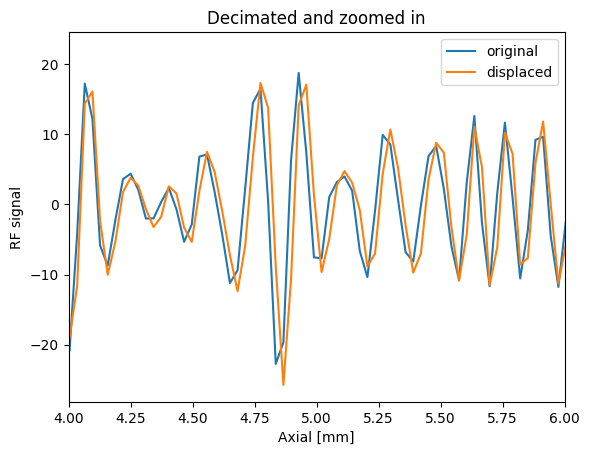

In [4]:
# Decimate
xs = x[::4]
s0 = trace0[::4]
s1 = trace1[::4]

plt.figure()
plt.plot(1E3*xs, s0, label='original')
plt.plot(1E3*xs, s1, label='displaced')
plt.legend()
plt.xlabel("Axial [mm]")
plt.ylabel("RF signal")
plt.title("Decimated")
plt.show()

plt.figure()
plt.plot(1E3*xs, s0, label='original')
plt.plot(1E3*xs, s1, label='displaced')
plt.legend()
plt.xlabel("Axial [mm]")
plt.ylabel("RF signal")
plt.title("Decimated and zoomed in")
plt.xlim(4,6)
plt.show()

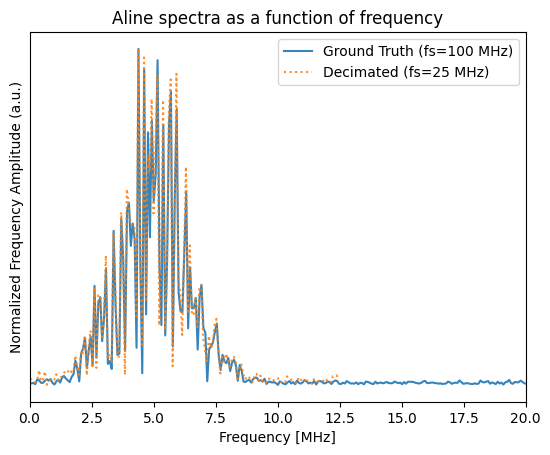

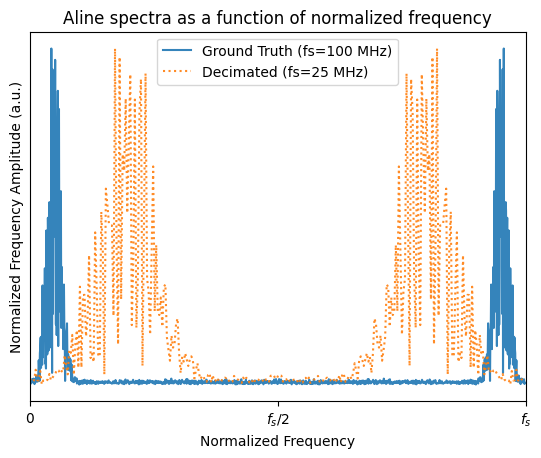

In [5]:
# calculate and compare the spectra of s0/trace0
spec = fft.fftshift(np.abs(fft.fft(trace0)))
freq = fft.fftshift(fft.fftfreq(len(x), 1E6/fs))
# freq[freq < 0] = 
spec = spec / np.max(spec)

fss = fs/4
specs = fft.fftshift(np.abs(fft.fft(s0)))
freqs = fft.fftshift(fft.fftfreq(len(xs), 1E6/fss))
specs = specs / np.max(specs)

plt.figure()
plt.plot(freq, spec, alpha = 0.9, label='Ground Truth (fs=100 MHz)')
plt.plot(freqs, specs, alpha = 0.9, linestyle=':', label='Decimated (fs=25 MHz)')
plt.legend()
plt.xlim(0, 20)
plt.yticks([])
plt.ylabel("Normalized Frequency Amplitude (a.u.)")
plt.xlabel("Frequency [MHz]")
plt.title("Aline spectra as a function of frequency")
plt.show()


plt.figure()
plt.plot(np.arange(len(trace0))/len(trace0), fft.fftshift(spec), alpha = 0.9, label='Ground Truth (fs=100 MHz)')
plt.plot(np.arange(len(s0))/len(s0), fft.fftshift(specs), alpha = 0.9, linestyle=':', label='Decimated (fs=25 MHz)')
plt.legend()
plt.xlim(0, 1)
plt.yticks([])
plt.ylabel("Normalized Frequency Amplitude (a.u.)")
plt.xticks([0, 1/2, 1], [0, "$f_s/2$", "$f_s$"])
plt.xlabel("Normalized Frequency")
plt.title("Aline spectra as a function of normalized frequency")
plt.show()

# Downsample and demodulate particel motion data in the frequency domain

- Verasonics RF data is typically sampled at $4 \times f_c$ to allow nyquist sampling at 200% bandwidth
    - Note: In this simulateion the decimated data is actually sampled at 25 MHz insted of 20 based on the center frequency of 5 MHz
- Given that RF data is real, it is symmetric in magnitude and antisymmetric in phase as a function of frequency, shown in the relation $X(f) = X^*(fs-f)$.
- Given that our probes realisticly are 60-80% fractional bandwidth, there are decent portions of the frequency domain that are basically zero and are dominated by noise signal
- To demodulate and downsample quickly, we can simply truncate the Fourier transform of the signal in the frequency domain to capture the unique positive frequencies that are below nyquist
- To remodulate, as long as the frequncy sampling is maintained and proper scaling is applied, we can upsample and remodulate easily
    - Note: upsampling and downsampling require different scaling factors - the calculateion of shich is not shown here. The package functions handle it automatically

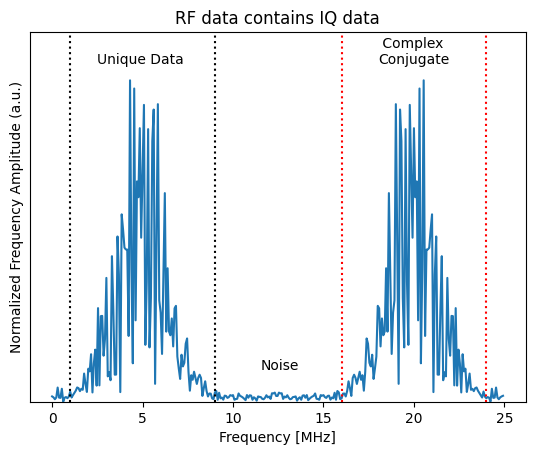

In [6]:
plt.figure()
plt.plot(1E-6*fss*np.arange(len(s0))/len(s0), fft.fftshift(specs))
plt.axvline(1, color='k', linestyle=':')
plt.axvline(9, color='k', linestyle=':')
plt.axvline(24, color='r', linestyle=':')
plt.axvline(16, color='r', linestyle=':')
plt.text(2.5, 1.05, "Unique Data")
plt.text(11.5, 0.1, "Noise")
plt.text(18, 1.05, " Complex\nConjugate")
plt.ylim(0, 1.15)
plt.yticks([])
plt.ylabel("Normalized Frequency Amplitude (a.u.)")
plt.xlabel("Frequency [MHz]")
plt.title("RF data contains IQ data")
plt.show()

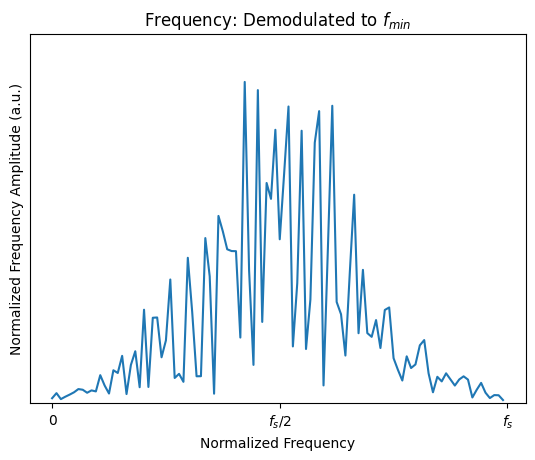

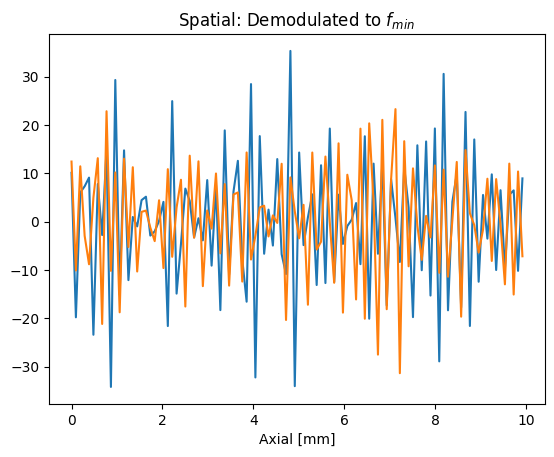

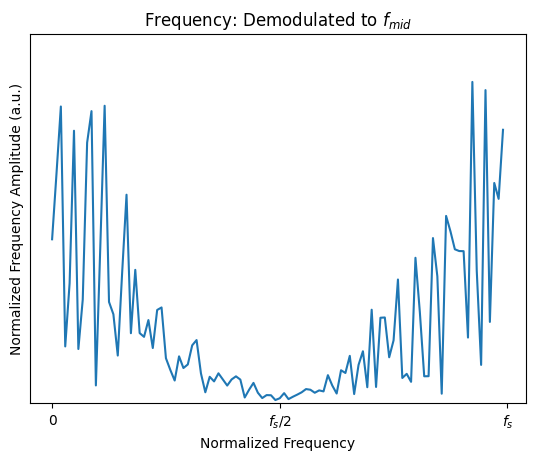

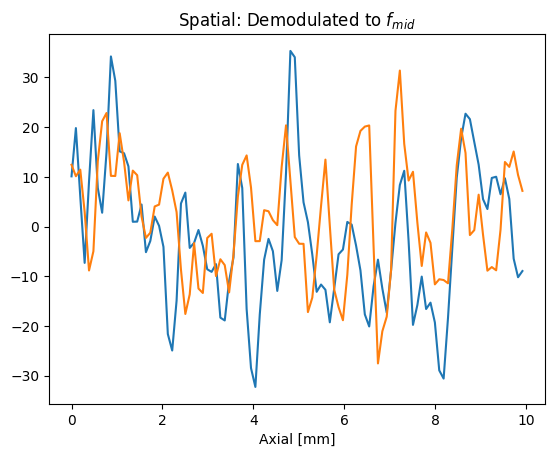

In [7]:
fmin = 1E6
fmax = 9E6
df = fss/len(s0)
if0min = int(fmin/df)
if0max = int(np.ceil(fmax/df))

TRUNC01 = fft.fft(s0)[if0min:if0max]
TRUNC00 = fft.ifftshift(fft.fft(s0)[if0min:if0max])
TRUNC1 = fft.ifftshift(fft.fft(s1)[if0min:if0max])

trunc00 = fft.ifft(TRUNC00)
trunc01 = fft.ifft(TRUNC01)
trunc1 = fft.ifft(TRUNC1)

env = np.abs(TRUNC01)
norm01 = env/np.max(env)

fs_trunc = df*len(trunc00)
x_trunc = xs[0] + c*np.arange(len(trunc00))/(2*fs_trunc)

fnorm = np.arange(len(TRUNC00))/len(TRUNC00)
plt.figure()
plt.plot(fnorm, norm01)
plt.xticks([0, 1/2, 1], [0, "$f_s/2$", "$f_s$"])
plt.ylim(0, 1.15)
plt.yticks([])
plt.ylabel("Normalized Frequency Amplitude (a.u.)")
plt.xlabel("Normalized Frequency")
plt.title("Frequency: Demodulated to $f_{min}$")
plt.show()

plt.figure()
plt.plot(1E3*x_trunc, np.real(trunc01))
plt.plot(1E3*x_trunc, np.imag(trunc01))
plt.xlabel("Axial [mm]")
plt.title("Spatial: Demodulated to $f_{min}$")
plt.show()

env = np.abs(TRUNC00)
norm00 = env/np.max(env)

plt.figure()
plt.plot(fnorm, norm00)
plt.ylim(0, 1.15)
plt.ylabel("Normalized Frequency Amplitude (a.u.)")
plt.yticks([])
plt.xticks([0, 1/2, 1], [0, "$f_s/2$", "$f_s$"])
plt.xlabel("Normalized Frequency")
plt.title("Frequency: Demodulated to $f_{mid}$")
plt.show()

plt.figure()
plt.plot(1E3*x_trunc, np.real(trunc00))
plt.plot(1E3*x_trunc, np.imag(trunc00))
plt.xlabel("Axial [mm]")
plt.title("Spatial: Demodulated to $f_{mid}$")
plt.show()

# Nicely wrapped functions

`demod_tensor` demodulates a given signal along the specified fast time axis. It selects the closest frequencies that included the input frequency bounds

In [10]:
from dispest import demod_tensor

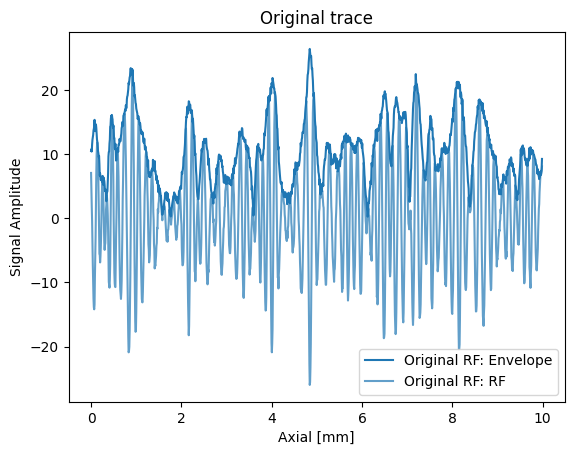

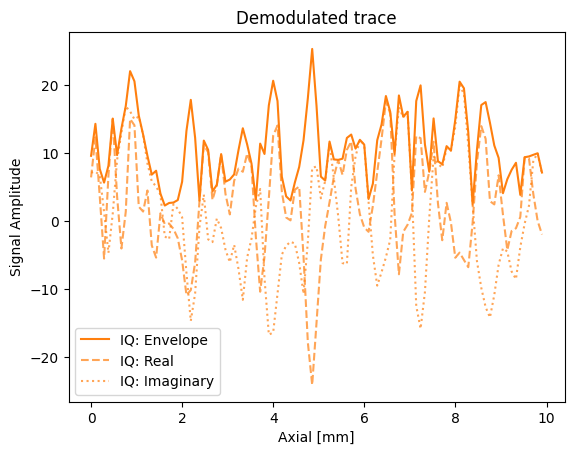

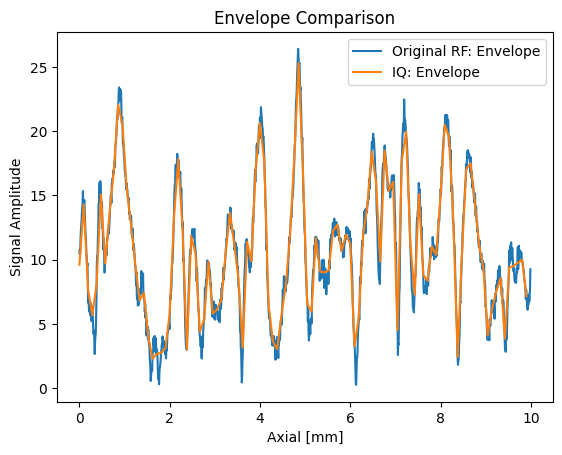

In [21]:
iq, ifmin, ifmax, fs_iq = demod_tensor(
    trace0,         # Signal to be demodulated
    fs,             # Sampling frequency of original signal
    fmin=1E6,       # minimum frequency that must be included
    fmax=9E6,       # maximum frequency that must be included
    taxis=0,        # axis of the data to be demodulated - works with ND tensors
    alpha = 0.15    # Alpha parameter of Tukey window used to taper the edges of the bandpass region
)

x_iq = x[0] + c*np.arange(len(iq))/(2*fs_iq)

plt.figure()
plt.plot(1E3*x, np.abs(sig.hilbert(trace0)), color='C0', alpha=1, linestyle='-', label='Original RF: Envelope')
plt.plot(1E3*x, trace0, color='C0', alpha=0.7, linestyle='-', label='Original RF: RF')
plt.xlabel("Axial [mm]")
plt.ylabel("Signal Amplitude")
plt.title("Original trace")
plt.legend()
plt.show()

plt.figure()
plt.plot(1E3*x_iq, np.abs(iq), color='C1', alpha=1, linestyle='-', label='IQ: Envelope')
plt.plot(1E3*x_iq, np.real(iq), color='C1', alpha=0.7, linestyle='--', label='IQ: Real')
plt.plot(1E3*x_iq, np.imag(iq), color='C1', alpha=0.7, linestyle=':', label='IQ: Imaginary')
plt.xlabel("Axial [mm]")
plt.ylabel("Signal Amplitude")
plt.title("Demodulated trace")
plt.legend()
plt.show()

plt.figure()
plt.plot(1E3*x, np.abs(sig.hilbert(trace0)), color='C0', alpha=1, linestyle='-', label='Original RF: Envelope')
plt.plot(1E3*x_iq, np.abs(iq), color='C1', alpha=1, linestyle='-', label='IQ: Envelope')
plt.xlabel("Axial [mm]")
plt.ylabel("Signal Amplitude")
plt.title("Envelope Comparison")
plt.legend()
plt.show()


In [12]:
from dispest import remod_tensor

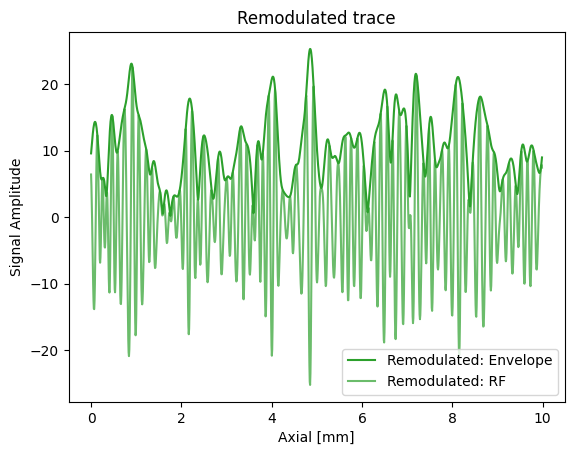

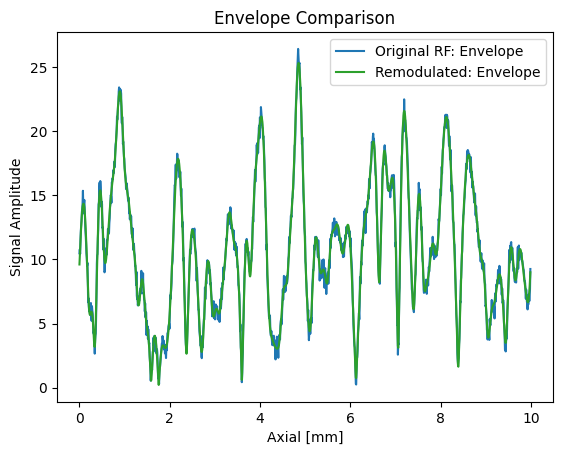

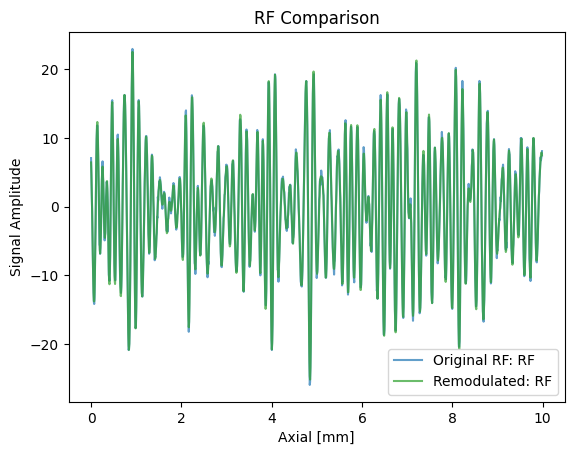

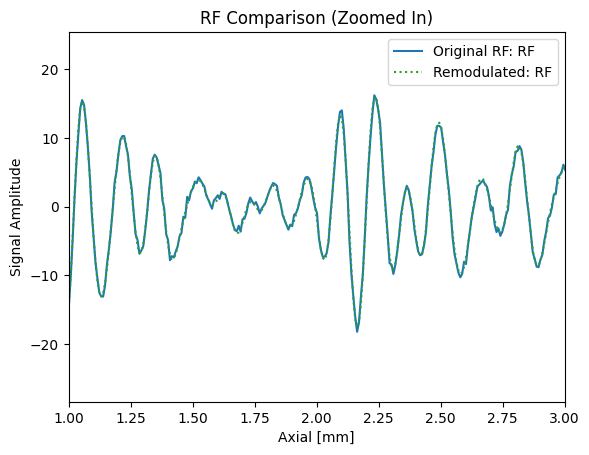

In [27]:
iq_remod, fs_remod = remod_tensor(
    iq,                     # the IQ signal to be remodulated
    fs_in=fs_iq,            # the sampling frequency of the IQ signal to be remodulated
    fs_out=fs,              # desired sampling frequency. The actual sampling frequency will be at least that
    ifmin=ifmin,            # Index of highest frequency being remodulated (returned from demod_tensor)
    ifmax=ifmax,            # Index of lowest frequency being remodulated (returned from demod_tensor)
    taxis=0,                # fast time axis of data
    return_complex=True     # whether to return IQ or RF signal
)

x_remod = x[0] + c*np.arange(len(iq_remod))/(2*fs_remod)

plt.figure()
plt.plot(1E3*x_remod, np.abs(iq_remod), color='C2', alpha=1, linestyle='-', label='Remodulated: Envelope')
plt.plot(1E3*x_remod, np.real(iq_remod), color='C2', alpha=0.7, linestyle='-', label='Remodulated: RF')
plt.xlabel("Axial [mm]")
plt.ylabel("Signal Amplitude")
plt.title("Remodulated trace")
plt.legend()
plt.show()

plt.figure()
plt.plot(1E3*x, np.abs(sig.hilbert(trace0)), color='C0', alpha=1, linestyle='-', label='Original RF: Envelope')
plt.plot(1E3*x_remod, np.abs(iq_remod), color='C2', alpha=1, linestyle='-', label='Remodulated: Envelope')
plt.xlabel("Axial [mm]")
plt.ylabel("Signal Amplitude")
plt.title("Envelope Comparison")
plt.legend()
plt.show()

plt.figure()
plt.plot(1E3*x, trace0, color='C0', alpha=0.7, linestyle='-', label='Original RF: RF')
plt.plot(1E3*x_remod, np.real(iq_remod), color='C2', alpha=0.7, linestyle='-', label='Remodulated: RF')
plt.xlabel("Axial [mm]")
plt.ylabel("Signal Amplitude")
plt.title("RF Comparison")
plt.legend()
plt.show()

plt.figure()
plt.plot(1E3*x, trace0, color='C0', alpha=1, linestyle='-', label='Original RF: RF')
plt.plot(1E3*x_remod, np.real(iq_remod), color='C2', alpha=1, linestyle=':', label='Remodulated: RF')
plt.xlabel("Axial [mm]")
plt.ylabel("Signal Amplitude")
plt.title("RF Comparison (Zoomed In)")
plt.xlim(1, 3)
plt.legend()
plt.show()